In [ ]:
def get_inter_event_timings(
    df: pd.DataFrame,
    event_1: str,
    event_2: str,
    event_disruptor: str = None,
    labels: list[str] = ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"],
    condition: str = None,
    return_df: bool = False,
    source_strategy: int = None,
):
    # Calculate the time difference between two events
    if condition is not None:
        df = df[df["condition"] == condition]
    ev1_label = f"{event_1}_pred"
    ev2_label = f"{event_2}_pred"
    order = orders[source_strategy]

    # If sequence event_1 > event_disruptor > event_2 is not in order, give error
    if event_disruptor is not None:
        if not (
            order.index(labels.index(event_1))
            == order.index(labels.index(event_disruptor)) - 1
            == order.index(labels.index(event_2)) - 2
        ):
            raise ValueError(
                f"Event sequence {event_1} > {event_disruptor} > {event_2} is not in the order {order}"
            )
    elif (
        not order.index(labels.index(event_1)) == order.index(labels.index(event_2)) - 1
    ):
        raise ValueError(
            f"Event sequence {event_1} > {event_2} is not in the order {order}"
        )
    df = df[df["order_idx"] == source_strategy]

    if return_df:
        return df
    else:
        diffs = df[ev2_label] - df[ev1_label]
        df = df[["condition", "epoch", "participant"]]
        df["difference"] = (diffs / 250) * 1000  # Convert to milliseconds
        df["disrupted"] = 1 if event_disruptor is not None else 0
        return df

<Axes: xlabel='sequence', ylabel='difference'>

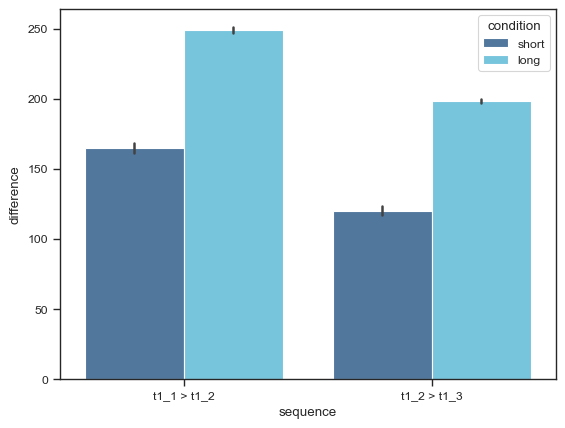

In [ ]:
results = []
for subsequence in [["t1_1", "t1_2"], ["t1_2", "t1_3"]]:
    timings = get_inter_event_timings(df, subsequence[0], subsequence[1], condition='short', source_strategy=0)
    timings["sequence"] = " > ".join(subsequence)
    timings_long = get_inter_event_timings(df, subsequence[0], subsequence[1], condition='long', source_strategy=0)
    timings_long["sequence"] = " > ".join(subsequence)
    results.append(timings)
    results.append(timings_long)
results = pd.concat(results)
results
set_seaborn_style()
sns.barplot(data=results, x="sequence", y="difference", hue="condition")

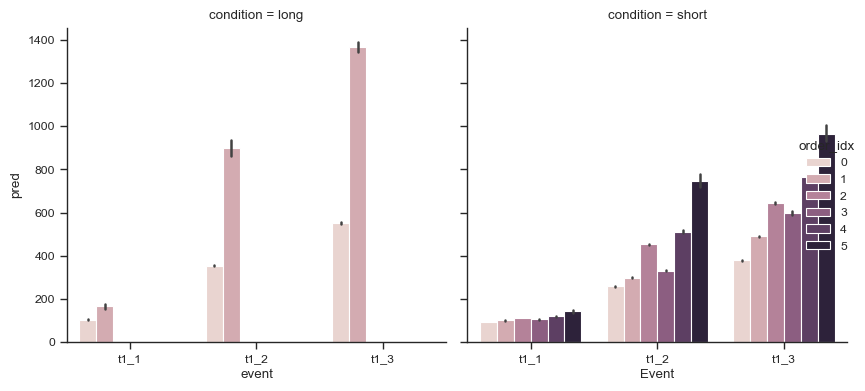

In [ ]:
# Convert to long-form and plot using sns barplot
df_long = df.melt(id_vars=["order_idx", "condition"], value_vars=["t1_1_pred", "t1_2_pred", "t1_3_pred"], var_name="event", value_name="pred")
# df_long = df_long[df_long['condition'] == 'short']
df_long['pred'] = df_long['pred'] / 250 * 1000
# Plot with facets by condition
set_seaborn_style()
sns.catplot(
    data=df_long,
    x="event",
    y="pred",
    hue="order_idx",
    col="condition",       # split plots by condition
    kind="bar",
    height=4,
    aspect=1
)
sns.barplot()
plt.ylabel("Predicted Time (ms)")
plt.xlabel("Event")
plt.xticks([0, 1, 2], ["t1_1", "t1_2", "t1_3"])
plt.tight_layout()
plt.show()

<Axes: xlabel='event', ylabel='pred'>

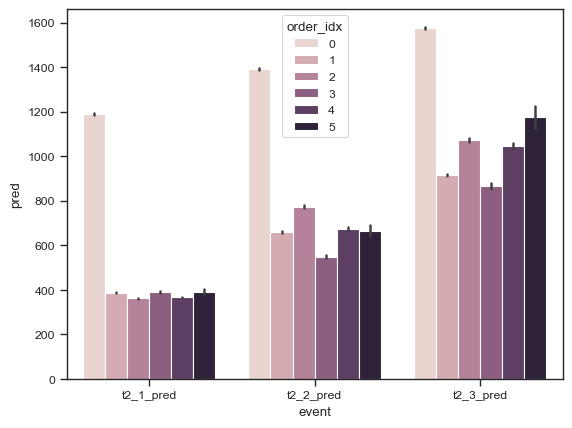

In [ ]:
# Convert to long-form and plot using sns barplot
df_long = df.melt(id_vars=["order_idx"], value_vars=["t2_1_pred", "t2_2_pred", "t2_3_pred"], var_name="event", value_name="pred")
df_long['pred'] = df_long['pred'] / 250 * 1000
sns.barplot(data=df_long, x="event", y="pred", hue="order_idx")

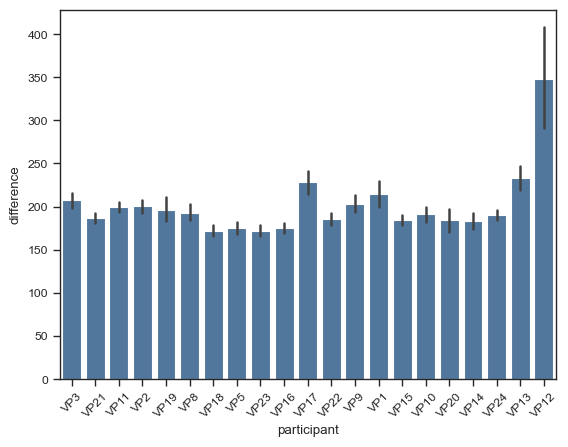

In [ ]:
timings = get_inter_event_timings(df, "t1_2", "t1_3", event_disruptor='t2_1', condition='short', source_strategy=1)
# Plot differences per participant
set_seaborn_style()
sns.barplot(timings, x="participant", y="difference")
plt.xticks(rotation=45)
plt.show()

In [ ]:
def plot_inter_event_timings(df, event_1, event_2, event_disruptor):
    set_seaborn_style()
    no_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=None, condition='short')
    with_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=event_disruptor, condition='short')
    df = pd.concat([no_disruption, with_disruption])
    sns.boxplot(data=df, x="disrupted", y="difference")
    # plt.xticks([0, 1], ['Not disrupted', f'Disrupted by {event_disruptor}'])
    plt.ylabel(f"Time between {event_1} and {event_2} (samples)")
    # plt.xlabel(f"Time between {event_1} and {event_2} (samples)")
    plt.show()

In [ ]:
plot_inter_event_timings(df, "t1_1", "t1_2", "t2_1")

In [ ]:
plot_inter_event_timings(df, "t1_2", "t1_3", "t2_1")

In [ ]:
plot_inter_event_timings(df, "t1_2", "t1_3", "t2_2")

In [ ]:
def get_disruptor_timings(df, event_1, event_2, event_disruptor, source='long', labels=["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"], source_strategy=(None, None, None)):
    # How long event_1 > event_2 usually takes
    no_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=None, condition=source, source_strategy=source_strategy[0])
    
    # How long event_1 > event_2 takes when event_disruptor is present
    with_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=event_disruptor, condition='short', source_strategy=source_strategy[1])

    # How long event_disruptor > next event usually takes 
    after_disruption = get_inter_event_timings(df, event_disruptor, labels[labels.index(event_disruptor) + 1], condition="short", source_strategy=source_strategy[2])
    # print(f"{event_disruptor} is followed by {labels[labels.index(event_disruptor) + 1]}")
    after_disruption["disrupted"] = 2

    print(f"Found {len(with_disruption)} disruptions (cases where {event_1} > {event_disruptor} > {event_2})")
    df = pd.concat([no_disruption, with_disruption, after_disruption])
    return df

def plot_all_timings():
    results = []
    for event_1, event_2 in [
        ("t1_1", "t1_2"),
        ("t1_2", "t1_3"),
        ("t2_1", "t2_2"),
        ("t2_2", "t2_3"),
        # ("t1_3", "t2_1"),	
    ]:
        for source in ["long", "short"]:
            combination_results = get_disruptor_timings(df, event_1, event_2, event_disruptor=None, source=source)
            combination_results["sequence"] = f"{event_1} > {event_2}"
            results.append(combination_results)
    results = pd.concat(results)
    return results

In [ ]:
results = []
for event_1, event_2 in [
    ("t1_1", "t1_2"),
    ("t1_2", "t1_3"),
    ("t2_1", "t2_2"),
    ("t2_2", "t2_3"),
    ("t1_3", "t2_1"),	
]:
    for source in ["long", "short"]:
        combination_results = get_disruptor_timings(df, event_1, event_2, event_disruptor=None, source=source)
        combination_results["sequence"] = f"{event_1} > {event_2}"
        results.append(combination_results)
results = pd.concat(results)

In [ ]:
((df[df['condition'] == 'short']['t1_2_pred'] / 250) * 1000).hist(bins=100, alpha=0.8, label='short')
((df[df['condition'] == 'long']['t1_2_pred'] / 250) * 1000).hist(bins=100, alpha=0.8, label='long')
plt.legend()
plt.show()

Disrupted sequences vs non-disrupted sequences, per unique disruption, uses only SHORT timings from default order

In [ ]:
def plot_disruptor_timings(df, event_1, event_2, event_disruptor):
    set_seaborn_style()
    combination_results = get_disruptor_timings(df, event_1, event_2, event_disruptor, source="short", source_strategy=[0, 1, 0])
    combination_results["sequence"] = f"{event_1} > {event_disruptor} > {event_2}"
    sns.boxplot(combination_results, x="sequence", y="difference", hue="disrupted", showfliers=False)
    plt.xlabel("Sequence")
    plt.ylabel("Time between events")
    plt.xticks(rotation=45)
    plt.show()

plot_disruptor_timings(df, "t1_2", "t1_3", "t2_1")

In [ ]:
results = []
for event_1, event_2, event_disruptor in [
    ("t1_1", "t1_2", "t2_1"),
    # ("t1_2", "t1_3", "t2_1"),
    # ("t1_2", "t1_3", "t2_2"),
    # ("t2_1", "t2_2", "t1_3"),
    # ("t2_2", "t2_3", "t1_3"),
]:
    combination_results = get_disruptor_timings(df, event_1, event_2, event_disruptor, source="short", source_strategy=[0, 2, 0])
    combination_results["sequence"] = f"{event_1} > {event_disruptor} > {event_2}"
    results.append(combination_results)

results = pd.concat(results)
set_seaborn_style()
sns.boxplot(results, x="sequence", y="difference", hue="disrupted", showfliers=False)
plt.xlabel("Sequence")
plt.ylabel("Time between events")
# plt.ylim(0, 500)
plt.xticks(rotation=45)
plt.show()

In [ ]:
results = []
for event_1, event_2, event_disruptor in [
    ("t1_1", "t1_2", "t2_1"),
    # ("t1_2", "t1_3", "t2_1"),
    # ("t1_2", "t1_3", "t2_2"),
    # ("t2_1", "t2_2", "t1_3"),
    # ("t2_2", "t2_3", "t1_3"),
]:
    combination_results = get_disruptor_timings(df, event_1, event_2, event_disruptor, source="short", source_strategy=[0, 4, 0])
    combination_results["sequence"] = f"{event_1} > {event_disruptor} > {event_2}"
    results.append(combination_results)

results = pd.concat(results)
set_seaborn_style()
sns.boxplot(results, x="sequence", y="difference", hue="disrupted", showfliers=False)
plt.xlabel("Sequence")
plt.ylabel("Time between events")
# plt.ylim(0, 500)
plt.xticks(rotation=45)
plt.show()

In [ ]:
for sequence in results["sequence"].unique():
    sequence_df = results[results["sequence"] == sequence]
    disr_0 = sequence_df[sequence_df["disrupted"] == 0]["difference"]
    disr_1 = sequence_df[sequence_df["disrupted"] == 1]["difference"]
    disr_2 = sequence_df[sequence_df["disrupted"] == 2]["difference"]

    n_boot = 10000
    boot_diffs = []
    for _ in range(n_boot):
        boot_0 = np.random.choice(disr_0, size=len(disr_0), replace=True).mean()
        boot_1 = np.random.choice(disr_1, size=len(disr_1), replace=True).mean()
        boot_2 = np.random.choice(disr_2, size=len(disr_2), replace=True).mean()
        diff = boot_2 - (boot_1 - boot_0)
        boot_diffs.append(diff)

    lower, upper = np.percentile(boot_diffs, [2.5, 97.5])
    print(f"{sequence} 95% CI: [{lower:.2f}, {upper:.2f}]")
# How much bigger the difference between disruptor > next is than the difference between event 1 > event 2 with and without disruptor

In [ ]:
from contextlib import redirect_stdout
import io, warnings

def model_inter_event_timings(df, event_1, event_2, event_disruptor, source='long'):
    no_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=None, condition=source)
    no_disruption['condition'] = 'long'
    with_disruption = get_inter_event_timings(df, event_1, event_2, event_disruptor=event_disruptor, condition='short')
    print(f"Found {len(with_disruption)} disruptions (cases where {event_1} > {event_disruptor} > {event_2})")
    df = pd.concat([no_disruption, with_disruption])
    df["disrupted"] = df["condition"] == 'short'
    df["participant"] = df["participant"].astype("category")
    df["condition"] = df["condition"].astype("category")

    formula = "difference ~ disrupted + (1|participant)"
    model = Lmer(formula, data=df)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with redirect_stdout(io.StringIO()):
            model.fit(verbose=False)

    # print(model.summary())
    return model

In [ ]:
def plot_modelled_inter_event_timings():
    results = []
    for event_1, event_2, event_disruptor in [
        ("t1_1", "t1_2", "t2_1"),
        ("t1_2", "t1_3", "t2_1"),
        ("t1_2", "t1_3", "t2_2"),
        ("t2_1", "t2_2", "t1_3"),
        ("t2_2", "t2_3", "t1_3"),
    ]:
        for source in ["long", "short", None]:
            model = model_inter_event_timings(
                df, event_1, event_2, event_disruptor, source=source
            )
            disruptor_effect = model.coefs["Estimate"].iloc[1].item()
            disruptor_effect_SE = model.coefs["SE"].iloc[1].item()
            combination_results = {
                "sequence": " > ".join([event_1, event_disruptor, event_2]),
                "source": source,
                "disruptor_effect": disruptor_effect,
                "disruptor_SE": disruptor_effect_SE,
            }
            results.append(combination_results)

    results = pd.DataFrame(results)
    results["source"] = results["source"].fillna("combined")
    set_seaborn_style()
    sns.lineplot(results, x="source", y="disruptor_effect", hue="sequence")
    plt.title("Inter-Event Timing (IET) disruption")
    plt.ylabel("Effect of disruption (ms) on IET")
    plt.xlabel("Source of valid IET")
    plt.xticks(rotation=45)
    plt.ylim(0, 200)
    plt.show()

In [ ]:
plot_modelled_inter_event_timings()

In [ ]:
# get_inter_event_timings(df, 't1_1', 't1_2', event_disruptor='t2_1', condition='short')['difference'].hist()
sns.violinplot(x=0, y=get_inter_event_timings(df, 't1_2', 't1_3', event_disruptor=None, condition='short')['difference'])
sns.violinplot(x=1, y=get_inter_event_timings(df, 't1_2', 't1_3', event_disruptor=None, condition='long')['difference'])

In [ ]:
model = model_inter_event_timings(df, "t1_1", "t1_2", "t2_1")